In [655]:
from bs4 import BeautifulSoup
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import requests
from sklearn.manifold import TSNE

import lyricsgenius as genius
import spotipy
import spotipy.util as util

# Setup API keys
import apiInfo

In [732]:
# Define useful functions here

def get_top_artists():
    """
    Get top performing hip-hop artists of 2010 decade from wikipedia using BeatifulSoup to scrape table
    Arguments:
        Takes in no arguments
    Returns:
        unique_artists -- a set of the top artists
    """
    WIKI_URL = "https://en.wikipedia.org/wiki/List_of_best-selling_hip-hop_albums_of_the_2010s_in_the_United_States"

    req = requests.get(WIKI_URL)
    soup = BeautifulSoup(req.content, 'html.parser')
    table_classes = {"class": ["sortable", "plainrowheaders"]}
    table = soup.find("table", { "class" : "wikitable sortable" })

    top_songs = pd.DataFrame()

    for row in table.find_all("tr"):
        cells = row.find_all("td")
        # some rows have 6 columns (for the year associated with all the albums in the year)
        # this handles the split in the data 
        if len(cells) == 6:
            year = cells[0].find(text=True)
            artist_list = cells[1].findAll(text=True)
            album = cells[2].find(text=True)
            label = cells[3].find(text=True)
            units = cells[4].find(text=True)
            cert = cells[5].find(text=True)
        elif len(cells) == 5:
            artist_list = cells[0].findAll(text=True)
            album = cells[1].find(text=True)
            label = cells[2].find(text=True)
            units = cells[3].find(text=True)
            cert = cells[4].find(text=True)
        if cells:
            for artist in artist_list:
                # hack-y way to handle edge cases for the Genius.com API
                artist = artist.replace("ASAP","A$AP")
                artist = artist.replace("Jay Z","JAY-Z")
                # Take care of multiple artists on list but account for Macklemore & Ryan Lewis
                if "&" not in artist or "Macklemore" in artist:
                    #removing some noise, won't translate well to analysis, we can filter any other artists here as well
                    if "various artist" not in artist:
                        top_songs = top_songs.append({'year':year, 'artist':artist, 'album':album,'label':label,'units':units,'cert':cert},ignore_index=True)
   
    # Use a set to get only the unique artists from the list
    unique_artists = set(top_songs['artist'])
    return unique_artists

def get_top_songs(artist):
    """
    Connect to Spotify API and return a list of an artists' top 10 songs
    Arguments:
        artist -- Artist name in string format
    Returns:
        top_track_list -- list object containing top 10 tracks of artist
    """
    token = util.oauth2.SpotifyClientCredentials(client_id=apiInfo.Spotify_client_id, client_secret=apiInfo.Spotify_client_secret)
    cache_token = token.get_access_token()
    spotify = spotipy.Spotify(cache_token)
    spotify_results = spotify.search(q='artist:' + artist, type='artist')
    # Get the ID of the top search result ... just assume the search returned something good
    spotify_artist_id = spotify_results['artists']['items'][0]['id']
    # Get the top tracks for the artist
    spotify_top_tracks = spotify.artist_top_tracks(spotify_artist_id)
    top_track_list = []
    for track in spotify_top_tracks['tracks']:
        top_track_list.append(track['name'])
    return top_track_list


def get_lyrics_from_artist(list_of_artists,max_songs=1):
    """
    Connect to the Genius.com API and scrape song lyric data
    Arguments:
        list_of_artists -- Artist names in a list of strings format
        max_songs       -- maximum number of songs to return, default is 1
    Returns:
        artist_dict -- Dictionary with artist as key and list of songs by artist as value
    """
    genius_api = genius.Genius(apiInfo.rapGeniusAPIkey)
    artist_dict = {}
    for artist in list_of_artists:
        song_list = []
        artist_results = genius_api.search_artist(artist,max_songs=max_songs,get_full_song_info=False,verbose=False)
        for song in artist_results.songs:
            song_list.append(song)
        artist_dict[artist] = song_list
    return artist_dict

def get_lyrics_from_songs(list_of_songs,artist):
    """
    Connect to the Genius.com API and scrape song lyric data
    Arguments:
        list_of_songs   -- List of songs associated with artist 
        artist          -- Artist to search for song titles under
    Returns:
        artist_dict -- Dictionary with artist as key and list of songs by artist as value
    """
    genius_api = genius.Genius(apiInfo.rapGeniusAPIkey)
    artist_dict = {}
    songList = []
    for song in list_of_songs:
        songList.append(genius_api.search_song(song,artist,verbose=False))
    artist_dict[artist] = songList
    return artist_dict

def build_doc_models_from_dict(artist_dict):
    """
    Build the word vector model from the artist dictionary generated above
    Arguments:
        artist_dict -- Dictionary with artist as key and list of songs by artist as value
    Returns:
        model_doc -- Doc2Vec object containing trained, labeled document vectors
    """
    class LabeledLineSentence(object):
        def __init__(self, doc_list, labels_list):
            self.labels_list = labels_list
            self.doc_list = doc_list
        def __iter__(self):
            for idx, doc in enumerate(self.doc_list):
                for song in doc:
                    yield gensim.models.doc2vec.TaggedDocument(song,[self.labels_list[idx]])
    
    songs_dict = {}
    
    # First, do some basic cleaning (check for empty lyrics) and do some preprocessing
    for artist,songs in artist_dict.items():
        songs_dict[artist] = []
        for song in songs:
            if song and hasattr(song,'lyrics') and isinstance(song.lyrics,str):
                songs_dict[artist].append(gensim.utils.simple_preprocess(song.lyrics))

    it = LabeledLineSentence( [songs for key,songs in songs_dict.items()], [key for key,songs in songs_dict.items()])
    
    model_doc = gensim.models.Doc2Vec(vector_size=300, min_count=0, alpha=0.05, min_alpha=0.025)
    model_doc.build_vocab(it)
    model_doc.train(it, epochs=50, total_examples=modelDoc.corpus_count)
    
    return model_doc

def get_artist_groupings(artist_dict,model_doc):
    """
    Generate artist groupings based on Doc2Vec model
    Arguments:
        artist_dict -- Dictionary with artist as key and list of songs by artist as value
        model_doc -- Doc2Vec object containing trained, labeled document vectors
    Returns:
        artist_groups -- Artist grouping with artist name as key and 2 most similar artists and artist as values
    """
    artist_groups = {}
    for artist_to_plot in artist_dict.keys():
        similar_artists = model_doc.docvecs.most_similar(artist_to_plot)
        similar_artists = [x[0] for x in similar_artists[:2] ]
        similar_artists.append(artist_to_plot)
        artist_groups[artist_to_plot] = similar_artists
    return artist_groups

def get_tsne_vectors(artist_dict,model_doc):
    """
    Generate 2D tSNE vectors and associated labels for each vector 
    Arguments:
        artist_dict -- Dictionary with artist as key and list of songs by artist as value
        model_doc -- Doc2Vec object containing trained, labeled document vectors
    Returns:
        vectors2d -- 2d vectors for all artists in Doc2Vec model
        labels --  list of artist names associated with the vectors by index in vectors2d
    """
    vecs = [ model_doc.docvecs[artist] for artist in artist_dict ]
    labels = [ x for x in artist_dict.keys()]
    tsne = TSNE(early_exaggeration=100,learning_rate=10, n_components=2, n_iter=10000, init='pca', random_state=50)
    vectors2d = tsne.fit_transform(vecs)
    return vectors2d,labels

def get_plotting_data(artist_to_plot,artist_groups,vectors2d,labels):
    """
    Generate 2D tSNE vectors and associated labels for each vector 
    Arguments:
        artist_to_plot -- Name of artist to plot
        artist_groups -- Artist grouping with artist name as key and 2 most similar artists and artist as values
        vectors2d -- 2d vectors for all artists in Doc2Vec model
        labels --  list of artist names associated with the vectors by index in vectors2d
    Returns:
        vec2plot_dict -- dictionary containing x/y lists for plotting data of similar and dissimlar artists
    """
    similar_artists = artist_groups[artist_to_plot]
    vec2plot_sim = [(x[0],x[1]) for x,y in zip(vectors2d,labels) if y in similar_artists ]
    vec2plot_not_sim = [(x[0],x[1]) for x,y in zip(vectors2d,labels) if y not in similar_artists ]
    vec2plotX_sim = [x[0] for x in vec2plot_sim]
    vec2plotY_sim = [x[1] for x in vec2plot_sim]
    vec2plotX_not_sim = [x[0] for x in vec2plot_not_sim]
    vec2plotY_not_sim = [x[1] for x in vec2plot_not_sim]
    vec2plot_dict = {"X_sim": vec2plotX_sim, "Y_sim":vec2plotY_sim, "X_not_sim":vec2plotX_not_sim, "Y_not_sim":vec2plotY_not_sim  }
    return vec2plot_dict

In [181]:
top_artists = get_top_artists()
artist_dict = get_lyrics_from_artist(top_artists,max_songs=100)

Timeout raised and caught


In [657]:
# Save dictionary into pickle file... takes a while to scrape

#with open('./artist_dict.pickle', 'wb') as handle:
#    pickle.dump(artist_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('artist_dict.pickle', 'rb') as handle:
    artist_dict = pickle.load(handle)

In [658]:
# Shuffle up the data and do some cleaning
for artist,songs in artist_dict.items():
    random.shuffle(songs)
#Need to remove duplicate J Cole (J. Cole already exists)
popped = artist_dict.pop("J Cole",None)

In [659]:
# For validation, split artists into training and validation sets
# Then, assign 80% of songs to training and keep 20% for validation
artist_dict_split= {}
for artist,songs in artist_dict.items():
    artist_dict_split[artist] = songs[:4*len(songs)//5]
    artist_dict_split[artist+"_val"] = songs[4*len(songs)//5:]

In [660]:
# Build our Doc2Vec models for both the training/validation and a model using all data
model_doc = build_doc_models_from_dict(artist_dict_split)
model_doc_orig = build_doc_models_from_dict(artist_dict)

In [661]:
# Determine our model accuracy
count =0
for artist in artist_dict.keys():
    most_similar = model_doc.docvecs.most_similar(artist)[0]
    print("Artist most similar to ", artist, " is ", most_similar[0].replace("_val",""), " with a score of ", most_similar[1])
    if str(artist) != str(most_similar[0].replace("_val","")):
        count +=1
print("Overall accuracy is found to be ",100*(1-count/len(artist_dict.keys())),"%")

Artist most similar to  Kid Cudi  is  Kid Cudi  with a score of  0.3177714943885803
Artist most similar to  G-Eazy  is  G-Eazy  with a score of  0.4969472587108612
Artist most similar to  Childish Gambino  is  Childish Gambino  with a score of  0.3669191598892212
Artist most similar to  T.I.  is  T.I.  with a score of  0.3767004609107971
Artist most similar to  2 Chainz  is  2 Chainz  with a score of  0.3542723059654236
Artist most similar to  Big Sean  is  Big Sean  with a score of  0.40636104345321655
Artist most similar to  Kid Ink  is  Kid Ink  with a score of  0.45526421070098877
Artist most similar to  Travis Scott  is  Post Malone  with a score of  0.3673275113105774
Artist most similar to  J. Cole  is  J. Cole  with a score of  0.32794320583343506
Artist most similar to  Meek Mill  is  Meek Mill  with a score of  0.37731391191482544
Artist most similar to  Drake  is  Drake  with a score of  0.3452484607696533
Artist most similar to  Nicki Minaj  is  Nicki Minaj  with a score of

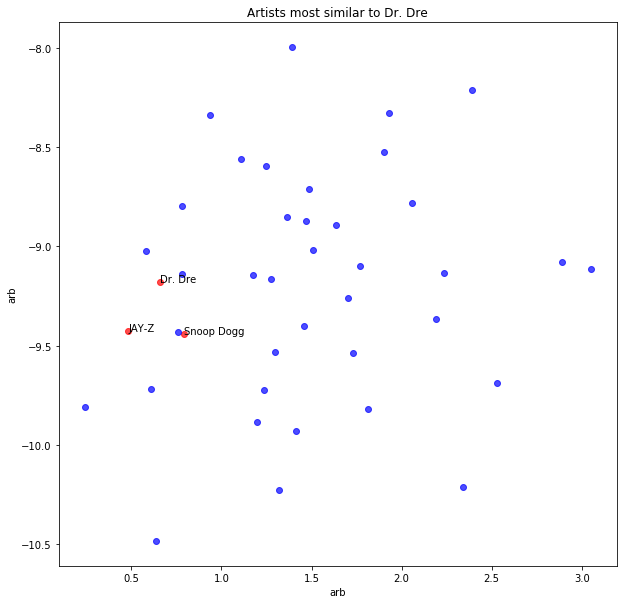

In [755]:
#Use t-SNE to plot Doc2Vec vectors in a 2D space
#Define artist to plot 
artist_to_plot = "Dr. Dre"

#First, define the groups (of artist and 2 closest neighbors) to plot together, by artist
artist_groups = get_artist_groupings(artist_dict,model_doc_orig)

#Setup vectors to feed into TSNE and create a nice labels list
vectors2d,labels = get_tsne_vectors(artist_dict,model_doc_orig)

# Generate x/y data
vec2plot_dict = get_plotting_data(artist_to_plot,artist_groups,vectors2d,labels)

# Finally, make plot with matplotlib and annotate
plt.figure(figsize=(10,10))
plt.scatter(vec2plot_dict['X_sim'],vec2plot_dict['Y_sim'], c='r', alpha=0.7)
plt.scatter(vec2plot_dict['X_not_sim'],vec2plot_dict['Y_not_sim'], c='b', alpha=0.7)
plt.xlabel("arb")
plt.ylabel("arb")
plt.title("Artists most similar to "+ artist_to_plot)
for i, txt in enumerate(artist_groups[artist_to_plot]):
    plt.annotate(txt, (vec2plot_dict['X_sim'][i],vec2plot_dict['Y_sim'][i]))

In [724]:
top_MFDOOM_songs = get_top_songs("MF DOOM")
MFDOOM_lyrics = get_lyrics_from_songs(top_MFDOOM_songs,"MF DOOM")
artist_dict_with_MFDOOM = {**artist_dict,**MFDOOM_lyrics}
model_doc_with_MFDOOM = build_doc_models_from_dict(artist_dict_with_MFDOOM)
model_doc_with_MFDOOM.docvecs.most_similar('MF DOOM')

[('Dr. Dre', 0.23854199051856995),
 ('Eminem', 0.2128099650144577),
 ('A$AP Rocky', 0.2012878656387329),
 ('B.o.B', 0.19962643086910248),
 ('Bad Meets Evil', 0.19568777084350586),
 ('Drake', 0.19282060861587524),
 ('Nicki Minaj', 0.1927437037229538),
 ('Lupe Fiasco', 0.19226598739624023),
 ('JAY-Z', 0.1758057177066803),
 ('Travis Scott', 0.17000633478164673)]

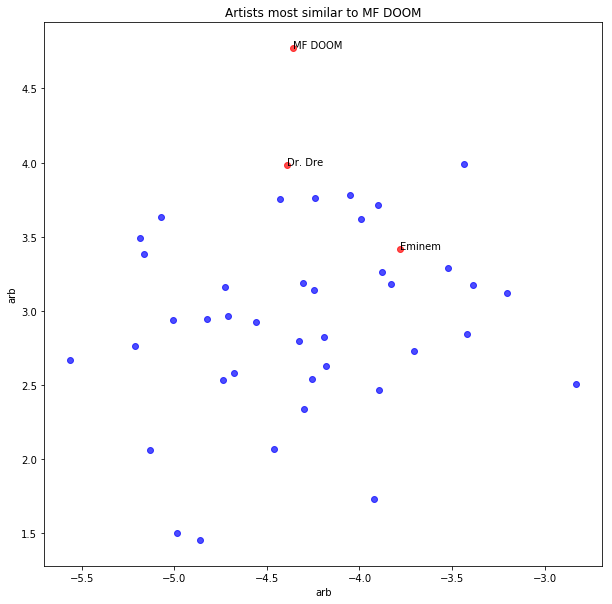

In [756]:
#Go through and redefine everything with MF DOOM to generate new plots

#Define artist to plot 
artist_to_plot = "MF DOOM"

#First, define the groups (of artist and 2 closest neighbors) to plot together, by artist
artist_groups = get_artist_groupings(artist_dict_with_MFDOOM,model_doc_with_MFDOOM)

#Setup vectors to feed into TSNE and create a nice labels list
vectors2d,labels = get_tsne_vectors(artist_dict_with_MFDOOM,model_doc_with_MFDOOM)

# Generate x/y data
vec2plot_dict = get_plotting_data(artist_to_plot,artist_groups,vectors2d,labels)

# Finally, make plot with matplotlib and annotate
plt.figure(figsize=(10,10))
plt.scatter(vec2plot_dict['X_sim'],vec2plot_dict['Y_sim'], c='r', alpha=0.7)
plt.scatter(vec2plot_dict['X_not_sim'],vec2plot_dict['Y_not_sim'], c='b', alpha=0.7)
plt.xlabel("arb")
plt.ylabel("arb")
plt.title("Artists most similar to "+ artist_to_plot)
for i, txt in enumerate(artist_groups[artist_to_plot]):
    plt.annotate(txt, (vec2plot_dict['X_sim'][i],vec2plot_dict['Y_sim'][i]))